[5장
](https://github.com/pymc-devs/resources/blob/master/BCM/ParameterEstimation/DataAnalysis.ipynb?fbclid=IwAR0zt0Rg6ZfHSPvJUd2BexlzUIIdzzL16ULnLIV-NwvCVRpm6_AFoodIvnE) 

[6장](https://github.com/pymc-devs/resources/blob/master/BCM/ParameterEstimation/Latent-mixtureModels.ipynb?fbclid=IwAR001TgQVWP-h-x7iA2cvhJmqhz8jQeQ8fk918_-OHfcAKnEZ3Kdn74O1tY)

책 76 ~ 91

In [35]:
from IPython.core.display import Image, display
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


# 5.1 Pearson correlation

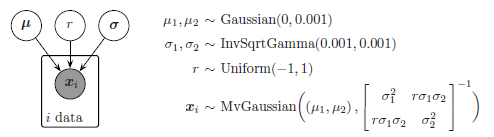

In [36]:
display(Image('./5_6_img/5_1.PNG', unconfined=True))

$-1 < r < 1$
* r : 두 변수의 measure of the relationship
* 단일 값 보다는 r의 사후 분포를 그리는 것이 더 유연한 접근 방식이다.
* x1, x2를 multivariate Gaussian Distribution에서 나왔다고 가정하자.
* $\sigma$는 noninformative하게 줘서 영향을 받지 않게 한다.
* $r$은 (-1,1)에서 다 나올 수 있으니 균등하게 uniform(-1,1)를 사전분포로 준다.

In [37]:
y = np.array([.8, 102, 1,98, .5 ,
              100, 0.9,105, .7,
              103,  0.4,110, 1.2,
              99, 1.4,87, 0.6,
              113, 1.1,89, 1.3, 93]).reshape((11, 2))

with pm.Model() as model:
    # r∼Uniform(−1,1) (prior)
    r =  pm.Uniform('r', lower=-1, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', 
                           tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                          [r*sigma1*sigma2, lambda2**-1]]))

    # xi∼MvGaussian((μ1,μ2),[σ1^2,rσ1σ2;rσ1σ2,σ2^2]^−1)
    yd = pm.MvNormal('yd', mu=mu, cov=cov, observed=y,shape=2)

    trace2=pm.sample(3000, njobs=2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda2, lambda1, mu, r]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:59<00:00, 118.09draws/s]
The acceptance probability does not match the target. It is 0.8798173345244048, but should be close to 0.8. Try to increase the number of tuning steps.


점을 시각화해보면 두 변수의 상관관계는 음수라는 것을 알 수 있다.

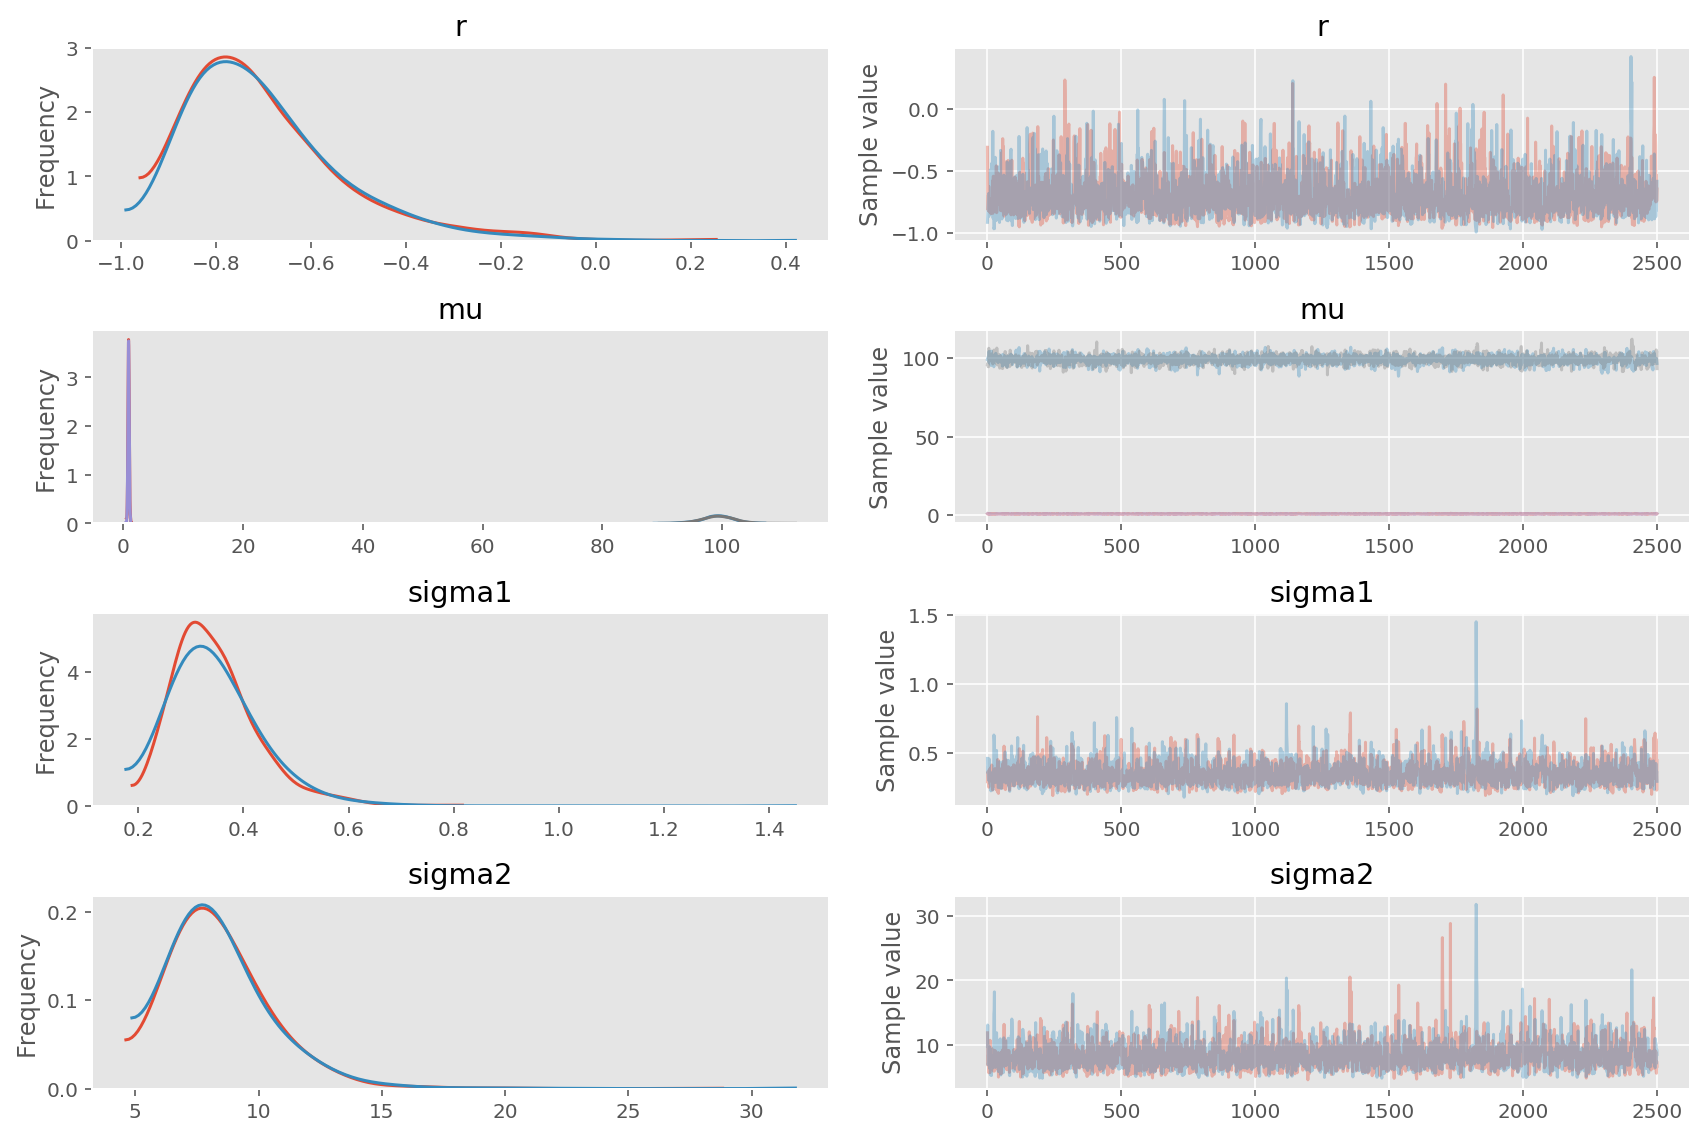

In [38]:
pm.traceplot(trace2[500:], varnames=['r', 'mu', 'sigma1', 'sigma2']);

The r estimation is:  -0.6941317204839897
The Pearson correlation r is:  -0.8109670756358501


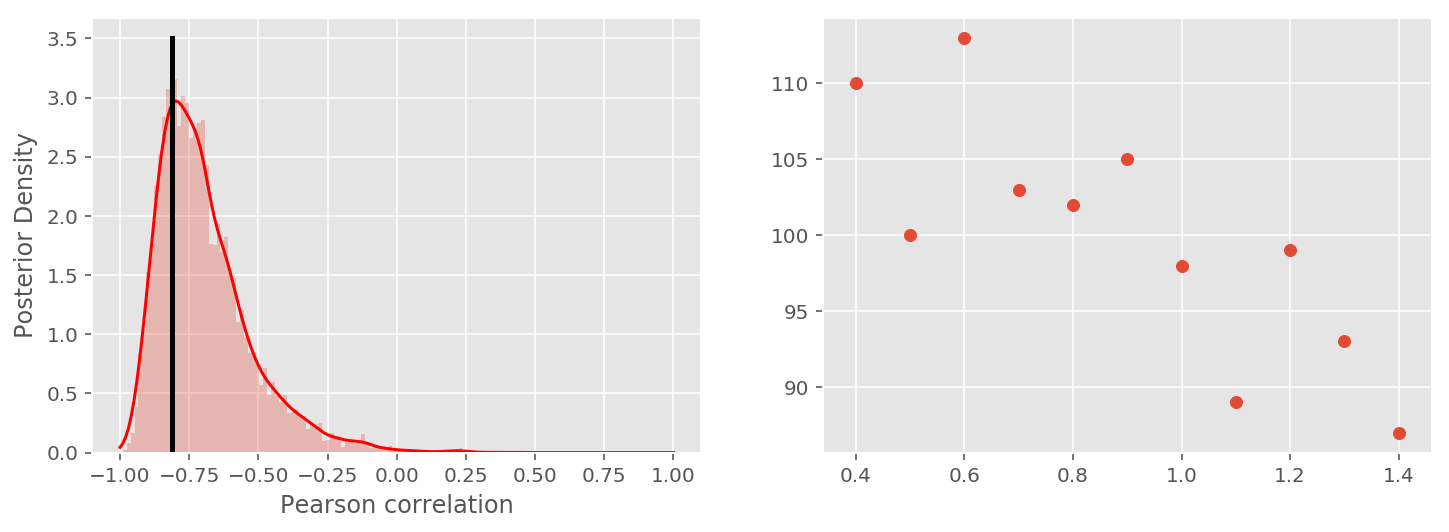

In [39]:

from matplotlib import gridspec
from scipy.stats.kde import gaussian_kde
import scipy as scipy 

r = trace2['r'][50:]
freqr = scipy.corrcoef(y[:, 0], y[:, 1])
print('The r estimation is: ', np.mean(r, axis=0))
print('The Pearson correlation r is: ', freqr[0, 1])

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax0.plot(x, my_pdf(x), 'r') # distribution function
ax0.hist(r, bins=100, normed=1, alpha=.3)
ax0.plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], 'k', lw=2.5)
plt.xlabel('Pearson correlation')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
ax1.scatter(y[:, 0], y[:, 1]);

# 5.2 Pearson correlation with uncertainty

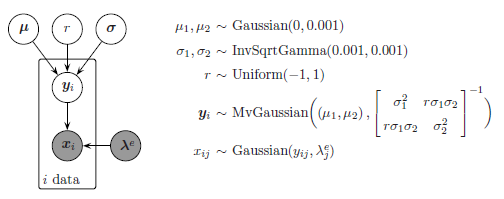

In [40]:
display(Image('./5_6_img/5_2.PNG', unconfined=True))

* 5.1문제에서는 완벽한 정확성을 가지고 관측치가 뽑혔다는 가정이 있다.
* 변수들의 정확한 값에 대한 불확실성을 느끼는 것을 고려하면서 상관계수(r)을 고려해야한다.
* ex) IQ 같은 psychological qunatity 같은 경우는 관측치에 대해서 확실성이 떨어질 수 있다.

In [41]:
# The datasets:
y = np.array([.8, 102, 1,98, .5,100, 0.9,105, .7,103, 
               0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((11, 2))
# y = np.array([.8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93,
#                .8,102, 1,98, .5,100, 0.9,105, .7,103, 
#                0.4,110, 1.2,99, 1.4,87, 0.6,113, 1.1,89, 1.3,93]).reshape((22, 2))

n1, n2 = np.shape(y)
sigmaerror = np.array([.03, 1])
## 0.03 : 반응시간은 정확할 것이라 생각해서 분산이 작게
## 1.0  : IQ는 오차가 더 클 수 있으므로 더 분산을 크게.
se = np.tile(sigmaerror, (n1, 1))

with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r = pm.Uniform('r', lower=-1, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))
    
    # xi∼MvGaussian((μ1,μ2),[σ1^2,rσ1σ2;rσ1σ2,σ2^2]^−1)
    yd = pm.MvNormal('yd', mu=mu, cov=cov, shape=(n1, n2))
    
    xi = pm.Normal('xi', mu=yd , sd=sigmaerror, observed=y)
    
    trace2=pm.sample(1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [yd, lambda2, lambda1, mu, r]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:53<00:00, 62.28draws/s] 
The acceptance probability does not match the target. It is 0.8802500979717437, but should be close to 0.8. Try to increase the number of tuning steps.


The r estimation is:  -0.7061006425829125
The Pearson correlation r is:  -0.8109670756358501


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


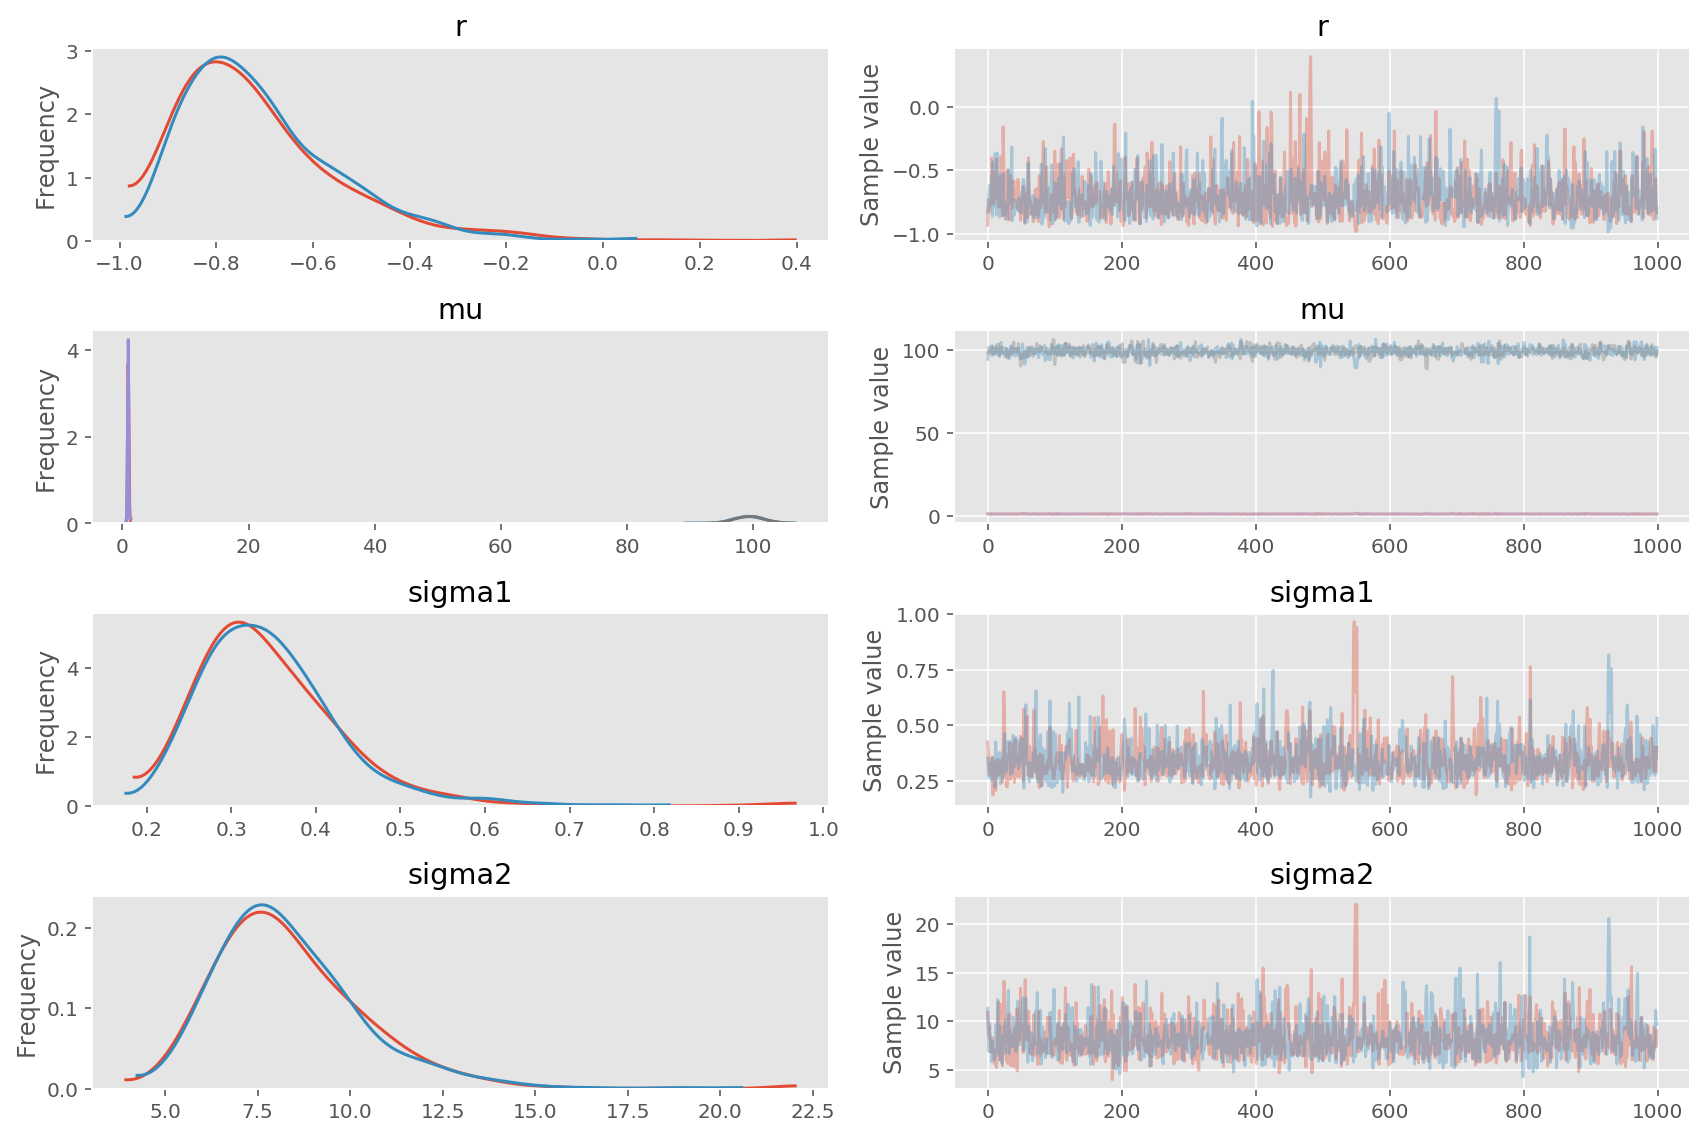

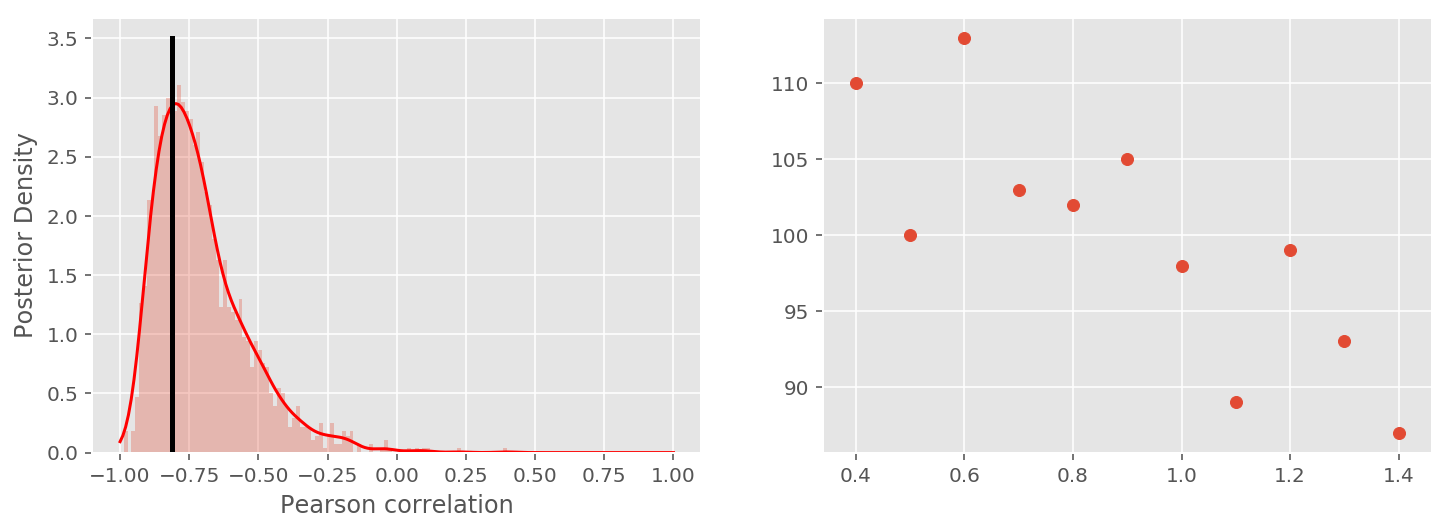

In [7]:
pm.traceplot(trace2, varnames=['r', 'mu', 'sigma1', 'sigma2']);

r = trace2['r']
freqr=scipy.corrcoef(y[:, 0], y[:, 1])
print('The r estimation is: ', np.mean(r, axis=0))
print('The Pearson correlation r is: ', freqr[0, 1])

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax0.plot(x, my_pdf(x), 'r') # distribution function
ax0.hist(r, bins=100, normed=1, alpha=.3)
ax0.plot([freqr[0, 1], freqr[0, 1]], [0, 3.5], 'k', lw=2.5)
plt.xlabel('Pearson correlation')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
ax1.scatter(y[:, 0], y[:, 1]);

# 5.3 The kappa coefficient of agreement

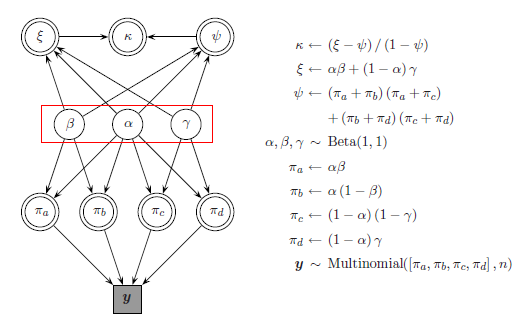

In [24]:
display(Image('./5_6_img/5_3.PNG', unconfined=True))

* 하나의 의사 결정 방법이 다른사람의 의사 결정 일치하는지 결정하는 것은 중요한 문제이다.
    * kappa 계수는 이러한 선택에 관해 측정 할 때 사용하는 계수이다.

* kappa는 범주형 자료의 일치도를 볼 때 사용하는 계수
    * kappa 작을수록 일치도가 낮다(우연히 일치했다.)
    * kappa 클수록 일치도가 높다
    * $Kappa = \frac{P_o - P_e}{1-P_e}$
    * $P_e$ : 우연히 두 평가자에 의하여 일최된 평가를 받은 비율
    * $P_o$ : 2명의 평가자간 일치 확률
    * kappa < 0.4 : Poor
    * 0.4 < Kappa < 0.75 Fair
    * 0.75 > Kappa Excellent
    
* Gold Standard : 진단을 확정 지을 수 있는 (즉 질병 유무를 판정할 수 있는) 좋은 척도

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gamma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1036.90draws/s]


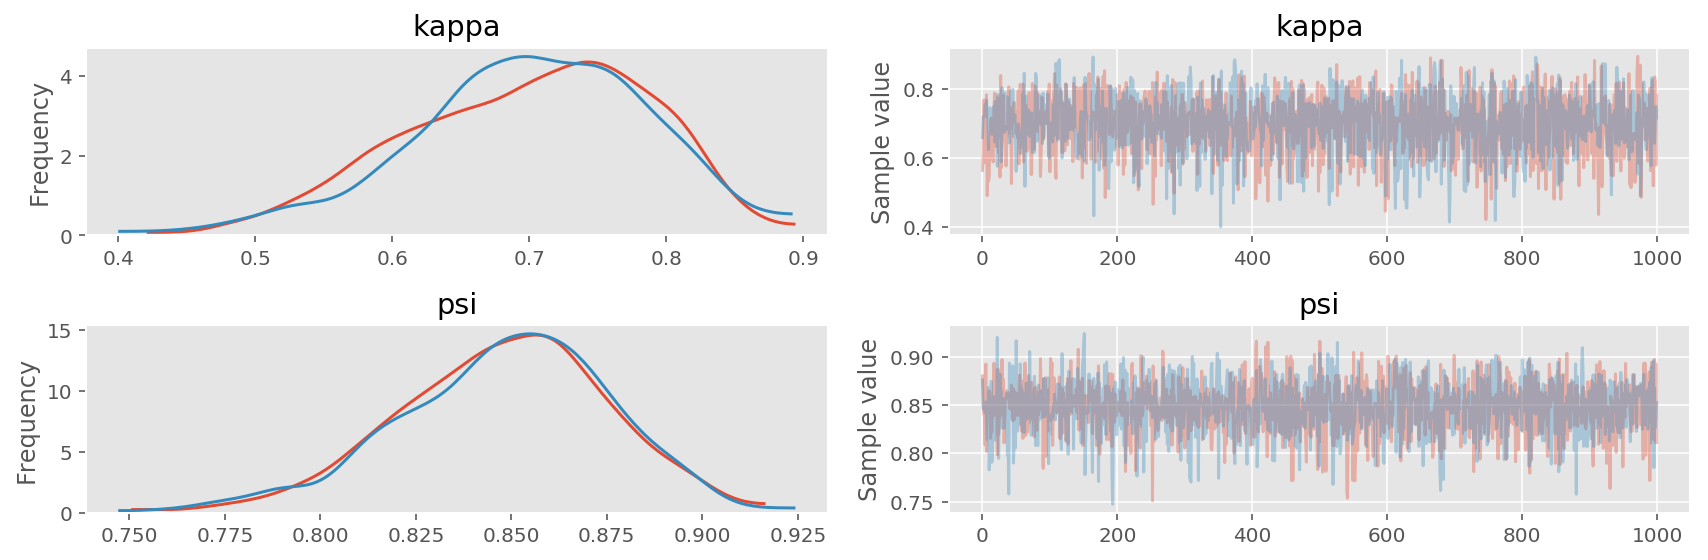

In [43]:
y = np.array([14, 4, 5, 210])
# Hearing Loss 
# y = np.array([20, 7, 103, 417])
# Rare Disease
# y = np.array([0, 0, 13, 157])

with pm.Model() as model1:
    # prior
    
    ## Gold standard 선택할 확률
    alpha = pm.Beta('alpha', alpha=1, beta=1)
    ## Gold Standard 선택 시 Surrogate도 선택할 확률
    beta = pm.Beta('beta', alpha=1, beta=1)
    ## Gold Standard 선택 안할 시 Surrogate도 선택 안할 확률
    gamma = pm.Beta('gamma', alpha=1, beta=1)
    ## 둘 다 선택 확률
    pi1 = alpha*beta
    ## Gold 선택하고 Surrogate 선택 안 할 확률
    pi2 = alpha*(1-beta)
    ## Gold 선택 안하고 Surrogate 선택 할 확률
    pi3 = (1-alpha)*(1-gamma)
    ## Gold 선택 안하고 Surrogate 선택 안할 확률
    pi4 = (1-alpha)*gamma
    
    # Derived Measures   
    # Rate Surrogate Method Agrees With the Objective Method
    ## P_o : 일치 할 경우
    xi = alpha*beta+(1-alpha)*gamma
    
    yd = pm.Multinomial('yd', n=y.sum(), p=[pi1, pi2, pi3, pi4], observed=y)

    # Rate of Chance Agreement
    ## 우연히 일치 할 경우 P_e
    psi = pm.Deterministic('psi', (pi1+pi2)*(pi1+pi3)+(pi2+pi4)*(pi3+pi4))
    
    # Chance-Corrected Agreement
    
    kappa = pm.Deterministic('kappa', (xi-psi)/(1-psi))
    
    trace=pm.sample(1000, njobs=2)

pm.traceplot(trace, varnames=['kappa', 'psi']);

# Compare to Cohen's point estimate
n = y.sum()
p0 = (y[0]+y[3])/n
pe = (((y[0]+y[1]) * (y[0]+y[2])) + ((y[1]+y[3]) * (y[2]+y[3]))) / n**2
kappa_Cohen = (p0-pe) / (1-pe)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Cohen's point estimate:  0.7357943807483934
MCMC estimate:  0.697194725896438


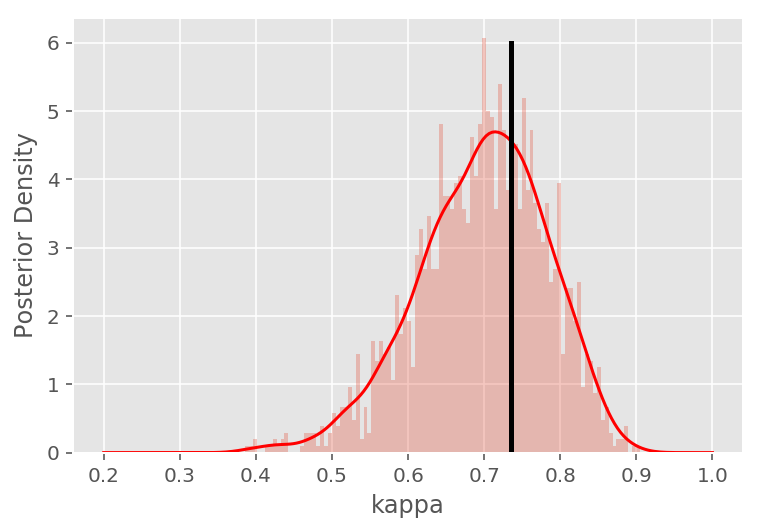

In [10]:
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde 
# for plotting: to calculate a continuous 
# approximation of the posterior and prior densities. 

kappa = trace['kappa']

my_pdf = gaussian_kde(kappa)
x = np.linspace(0.2, 1, 200)
plt.plot(x, my_pdf(x), 'r') # distribution function

plt.hist(kappa, bins=100, normed=1, alpha=.3)
plt.plot([kappa_Cohen, kappa_Cohen], [0, 6], 'k', lw=2.5)
plt.xlabel('kappa')
plt.ylabel('Posterior Density');

print("Cohen's point estimate: ", kappa_Cohen)
print("MCMC estimate: ", np.mean(kappa))

# 5.4 Change detection in time series data

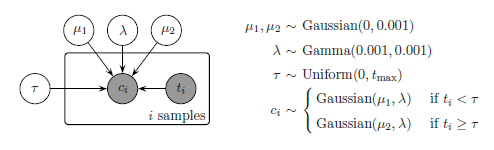

In [14]:
display(Image('./5_6_img/5_4.PNG', unconfined=True))

* 시간이 지남에 따라 집중력의 변화에 대해서 모델링
* 변화가 있는지 없는지를 확인하는 것이 통계적인 문제이다.
* 강한 가설
    * 가우시안 분포로 나오고 같은 분산을 가진다.
    * 그러나 특정 시간에 변화가 생긴다.
    * $\tau$는 관측되지는 않았지만 변화가 되는 시점을 나타내는 변수

In [44]:
dat = pd.read_csv('https://raw.githubusercontent.com/\
junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3/\
master/ParameterEstimation/\
changepointdata.csv')

In [45]:
dat.shape

(1178, 1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [lambd, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.85draws/s]
The acceptance probability does not match the target. It is 0.9022049934133958, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


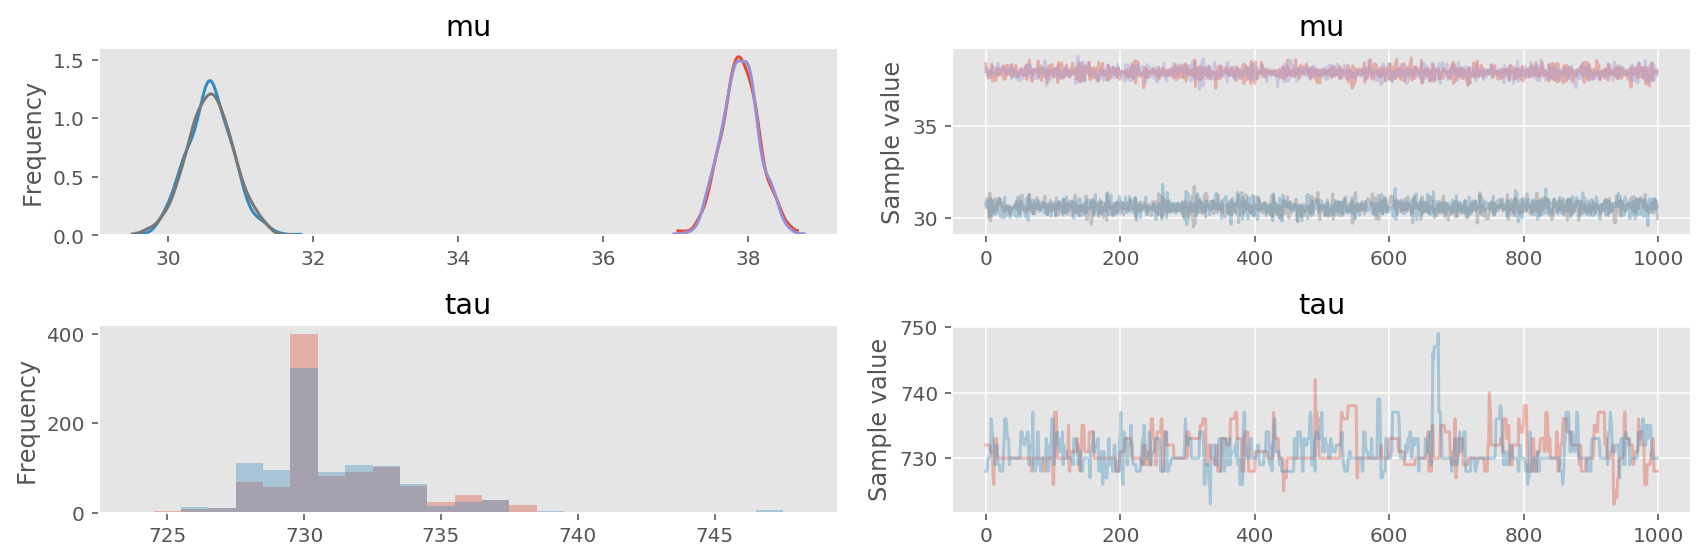

In [46]:
# pymc3
# Load data
c = dat.data
n = np.size(c)
sample = np.arange(0, n)

with pm.Model() as model3:
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=2)
    # λ∼Gamma(.001,.001)
    lambd = pm.Gamma('lambd', alpha=.001, beta=.001)
    #　τ∼Uniform(0,tmax)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    
    muvect = pm.math.switch(tau>=sample, mu[0], mu[1])

    cobs = pm.Normal('cobs', mu=muvect, tau=lambd, observed=c)
    
    trace1=pm.sample(1000, njobs=2)

pm.traceplot(trace1, varnames=['mu', 'tau']);

[37.88891528 30.57459429]
731


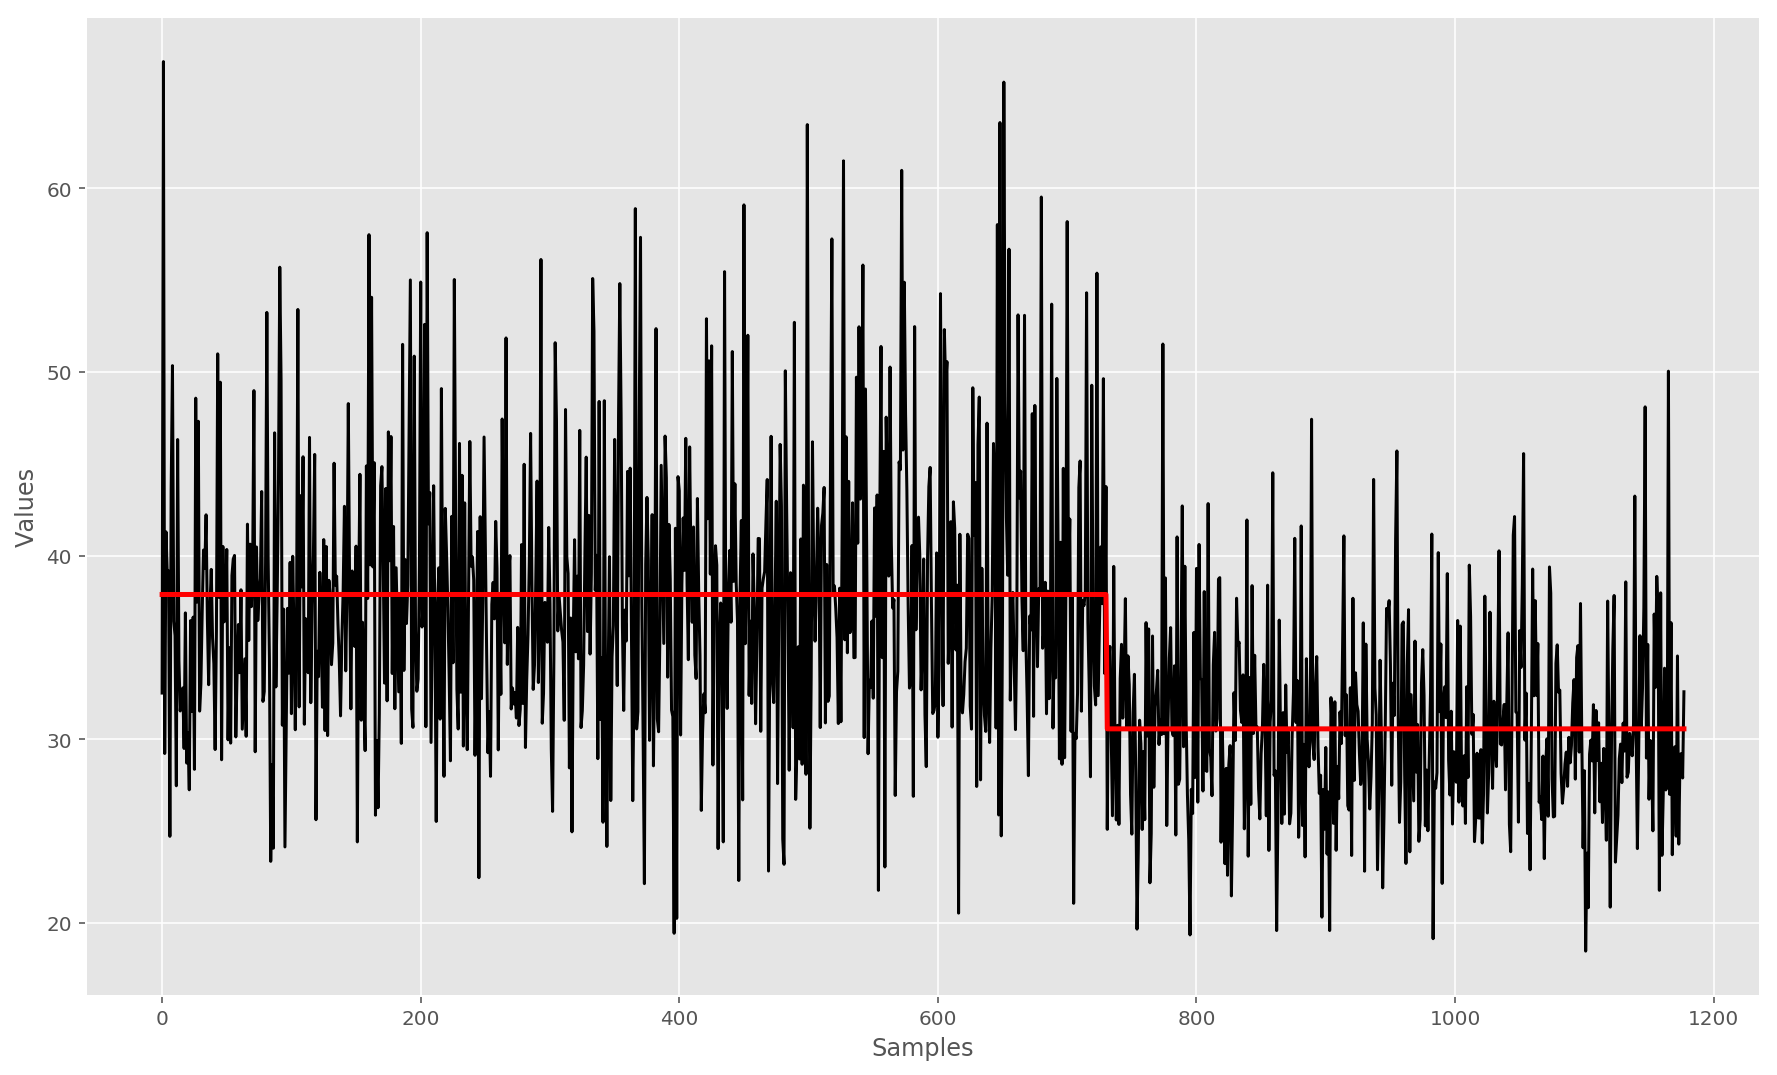

In [47]:

MCtau = trace1['tau'][100:]
MCmu = trace1['mu'][100:]

mu1 = np.mean(MCmu, axis = 0)
tau1 = int(np.mean(MCtau))
fited = np.zeros(n)
fited[:tau1] = np.ones(tau1)*mu1[0]
fited[tau1:] = np.ones(n-tau1)*mu1[1]

plt.figure(1, figsize=(15, 9))
plt.plot(np.arange(0, n, 1), c, color='k')
plt.plot(np.arange(0, n, 1), fited, color='r', lw=2.5)
plt.xlabel("Samples")
plt.ylabel("Values");

print (mu1)
print (tau1)

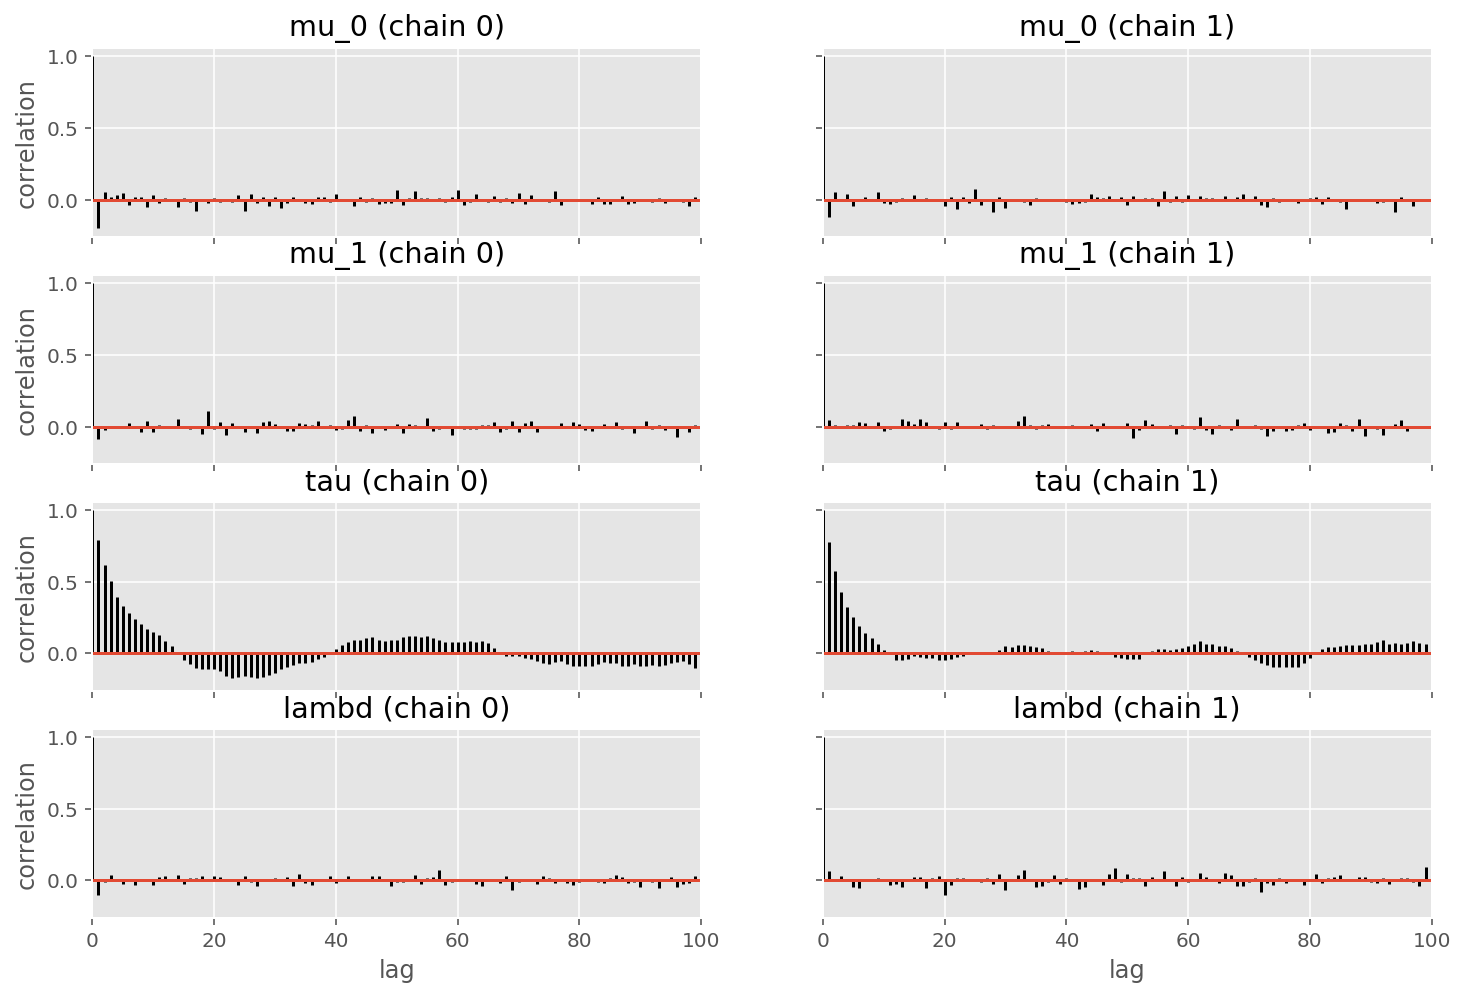

In [50]:
from pymc3 import *
plots.autocorrplot(trace1)
plt.show()

# 5.5 Censored data

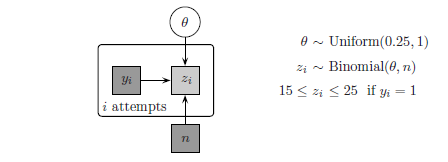

In [15]:
display(Image('./5_6_img/5_5.PNG', unconfined=True))

* 차 운전 시험 패스하기위해 계속 노력하는 한 할머니
* 50문제 사지 선다형
* 100점만점에 60점 이상이면 통과
* 가정
    * 각 점수는 2점씩 30개를 맞춰야 통가 가능하다.
* 950번째 시험에서 합격함
* 0~949번까지 맞은 답은 15~25개 사이라고 함.
* `문제`
    * 한 문제에 얼마나 정확하게 답할 지에 대한 확률은?
    * 가정 시험문제는 매번 어려웠고, 이전 시험에서 배울 수 없었다.
* $z_i$ = 1~949와 950번 통과 여부 표현(partially observed)
* 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:03<00:00, 1808.64draws/s]


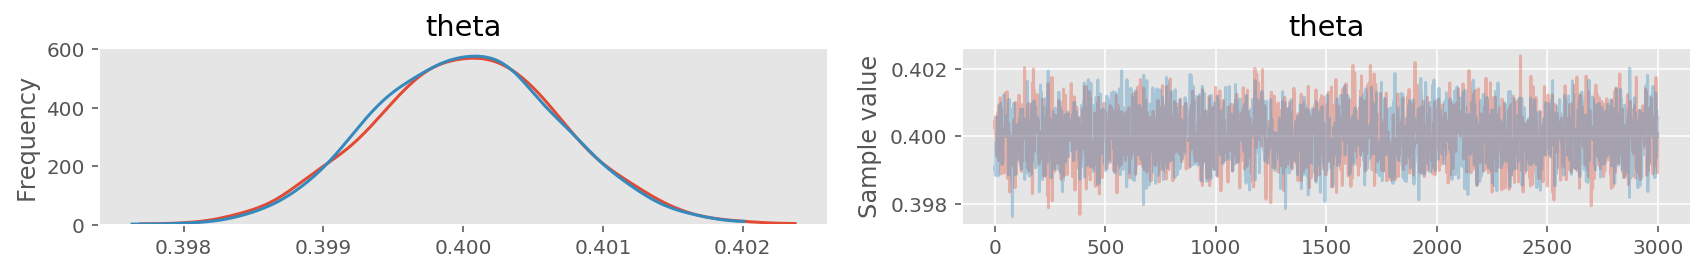

In [52]:
nattempts = 950   
nfails = 949   
n = 50    # Number of questions
y = np.zeros(nattempts)
y[nattempts-1] = 1
z = 30
unobsmin = 15
unobsmax = 25
unobsrange = np.arange(unobsmin, unobsmax+1)
from pymc3.distributions import dist_math

def logp(value, n, p):
    return dist_math.bound(dist_math.binomln(n, value) + 
                          dist_math.logpow(p, value) + 
                          dist_math.logpow(1-p, n-value),
                          0 <= value, value <= n,
                          0 <= p, p <= 1)
def Censorlike(value=z, n=n, censorn=nfails, unobs=unobsrange):
    ylikeobs = logp(value=value, n=n, p=theta)
    ylikeunobs = 0
    for i in unobs:
        ylikeunobs += logp(value=i, n=n, p=theta)
    return ylikeobs*1 +ylikeunobs*censorn
    
with pm.Model():
    theta = pm.Uniform('theta', lower=.25, upper=1)
    
    ylike = pm.DensityDist('ylike', Censorlike, 
                           observed={'value': z, 'n': n, 'censorn': nfails, 'unobs': unobsrange})
    trace = pm.sample(3000, njobs=2)

pm.traceplot(trace);

## 5.6 Recapturing planes

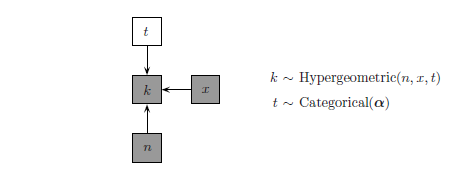

In [12]:
display(Image('./5_6_img/5_6.PNG', unconfined=True))

* 많은 분야에서 발생하는 흥미로운 추론 문제는 전체 조사가 불가능할 때 인구 규모를 추정하는 것이지만 반복적인 측량은 가능하다.
* ex) 큰 숲에서 동물의 수를 추정하기
* 이러한 문제에서 좋은 샘플링 방법은 `capture-and-recapture` 방법이다.
    * 한 시점에서 표본을 얻고 또다른 샘플을 모으는 것이다.
    * 그때 high recapture 라면 모집단은 작다 할 수 있고, 반대는 크다 할 수 있다.
    * 이러한 개념은 초기하 분포로 생각할 수 있다.
    * k ~ Hypergeometric(n,x,t)
    * x(전체에서 구하고자 하는 수)  n(샘플수) t(전체수)
    
* 문제
    * 비행기 한 시점에서 유니크한 항공기 10 
    * 몇 일 후에 다른 공항에서 같은 회사 비행기에서 끝짜리가 같은 비행기 4개 
    
$P(k) =  \frac{{x \choose k} {t-x \choose n-k}}{{t \choose n}} $

In [33]:
# pymc3 - Hypergeometric Likelihood Via Zeros Trick as in JAGS

x = 10 # number of captures
k = 4  # number of recaptures from n
n = 5  # size of second sample
tmax = 50 # maximum population size

factln = dist_math.factln
with pm.Model():
    tau = pm.DiscreteUniform("tau", lower=x + (n-k), upper=tmax)
    logterm1 = factln(x+.01) - factln(k+.01) - factln(x-k+.01)
    logterm2 = factln(tau-x+.01) - factln(n-k+.01) - factln((tau-x)-(n-k)+.01)
    logterm3 = factln(tau+.01) - factln(n+.01) - factln(tau-n+.01)
    C = 1000
    phi = -(logterm1+logterm2-logterm3)+C 
    
    obs = pm.Poisson("obs", mu=phi, observed=0)
    trace = pm.sample(3000)
    
tau = trace['tau']



Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:01<00:00, 10262.56draws/s]
The number of effective samples is smaller than 10% for some parameters.


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


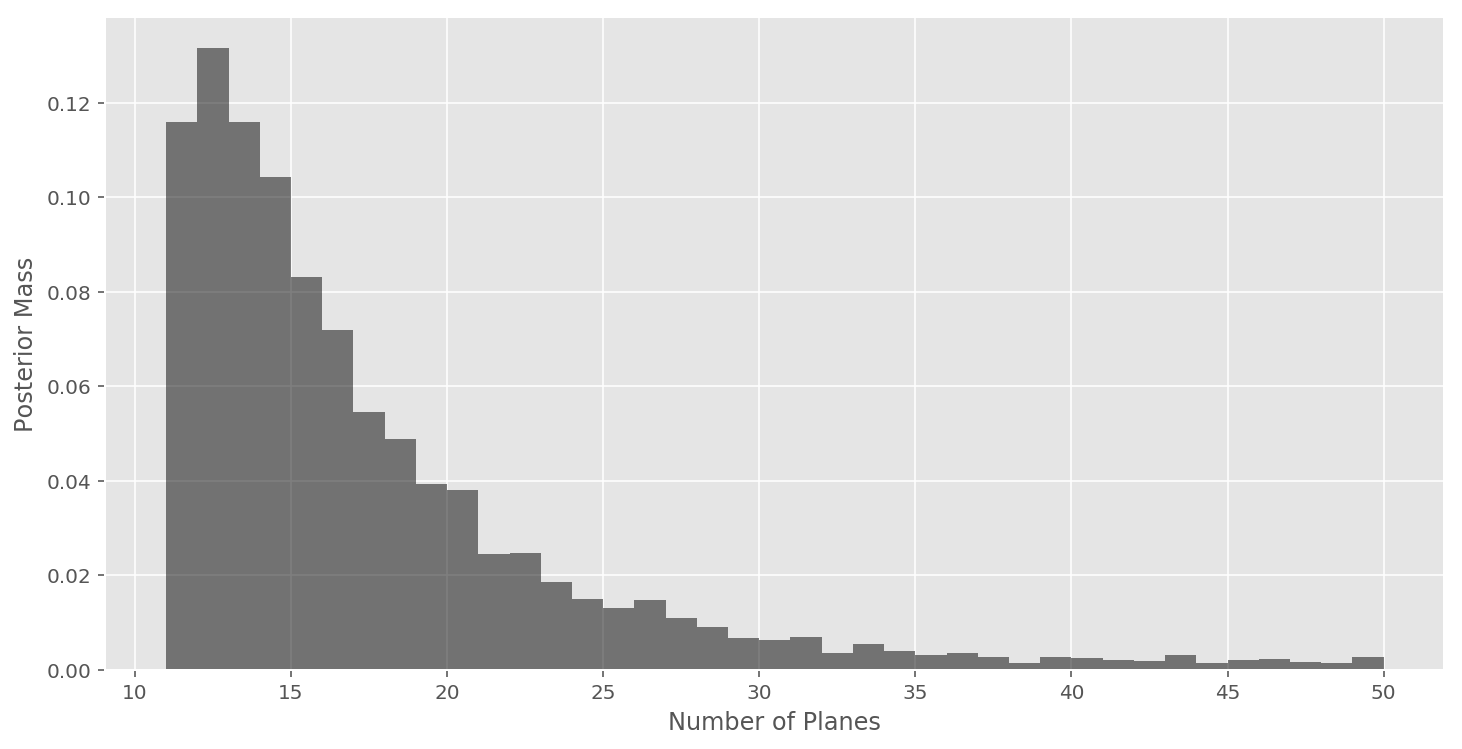

In [34]:
plt.figure(figsize=(12, 6)) 
plt.hist(tau, bins=tmax - (x + (n-k)), normed=1,alpha=.5,color='k')
plt.xlabel('Number of Planes')
plt.ylabel('Posterior Mass');

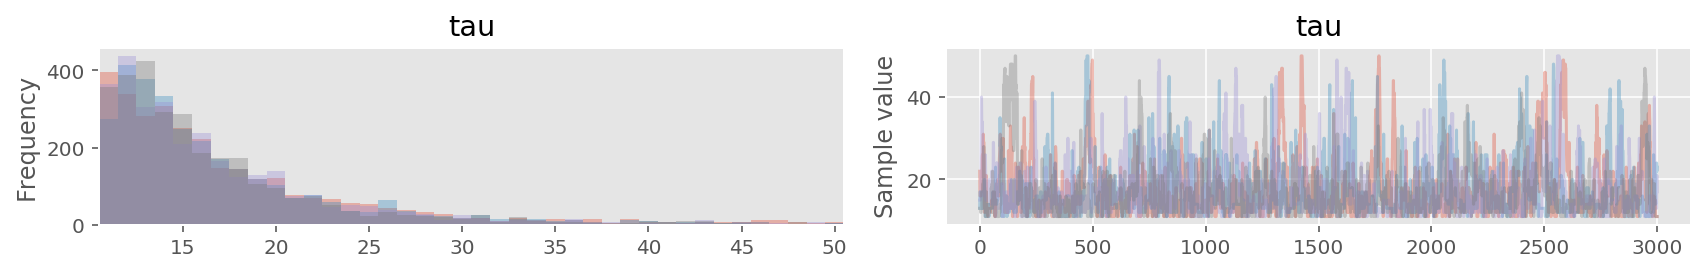

In [35]:
pm.traceplot(trace);